### Note:
Suggestions for plotting and data visualization would be highly appreciated

In [2]:
# imports
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torch.nn import functional as F
import torch.optim as optim

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from tqdm.notebook import tqdm

%matplotlib inline
plt.style.use('fivethirtyeight')


import warnings
warnings.filterwarnings('ignore')

import os

## Data Preparation
I find having organized classes / functions for handling repeatable tasks making it easier, cleaner and can be used in other projects

In [11]:
class DataPreparation(object):
    def __init__(self, root_path):
        self.root_path = root_path
        self.X_train = None
        self.X_val = None
        self.y_train = None
        self.y_val = None
    
    # Read in the data to a pandas dataframe
    def get_dataframe(self, filename):
        file_path = os.path.join(self.root_path, filename)
        print(f"Loading data file: {file_path}")

        df = pd.read_csv(
            file_path,
            sep=',',
            #parse_dates=['date'],
            #infer_datetime_format=True,
            low_memory=False
        )

        X = df.copy()
        return X
    
    # Get a summary of the data
    def summary(self, df):
        summary = pd.DataFrame(df.dtypes, columns=['dtypes'])
        summary['null'] = df.isnull().sum()
        summary['unique'] = df.nunique()
        summary['min'] = df.min()
        summary['median'] = df.median()
        summary['max'] = df.max()
        summary['mean'] = df.mean()
        summary['std'] = df.std()
        summary['duplicate'] = df.duplicated().sum()

        return summary
    
    # Standardization
    def standardization(self, X_data):
        scaler = StandardScaler()
        std_X_data = scaler.fit_transform(X_data)
        return std_X_data
    
    
    # Preprocess data
    def preprocessing(self, df, labels_to_encode, labels_to_drop, split_ratio, target_label):
        """
            Apply label encoding, drop columns and split the data
        """
        X = df.copy()
        if len(labels_to_encode) != 0:
            for label in labels_to_encode:
                X[label] = LabelEncoder().fit_transform(X[label])
        
        # Remove ID columns
        X = X.loc[:, X.columns != 'id']
        y = X[target_label]

        # Drop labels
        if len(labels_to_drop) != 0:
            X.drop(columns=labels_to_drop, axis = 1, inplace = True)
        
        # split the data
        X_train, X_val, y_train, y_val = train_test_split(
            X,
            y, 
            test_size=split_ratio, 
            shuffle=False, 
            random_state=42
        )

        self.X_train = X_train
        self.X_val = X_val
        self.y_train = y_train
        self.y_val = y_val

        return self.X_train, self.X_val, self.y_train, self.y_val

Load the dataset and print a summary

In [12]:
dataprep = DataPreparation('./')
train = dataprep.get_dataframe('Cancer_Data.csv')
train = train.dropna(axis=1, inplace=False)

Loading data file: ./Cancer_Data.csv


Our target is `Diagnosis` where the cancer type is classified as Benign or Malignant.
Using our DataPreparation class we can:
1. Set the target (`diagnosis`)
2. Split the data
3. Drop the ID column
4. Drop the `diagnosis` column from our X dataset (X_train, X_val)

In [13]:
X_train, X_val, y_train, y_val = dataprep.preprocessing(train, ['diagnosis'], [], 0.25, 'diagnosis')
X_train = X_train.drop(['diagnosis'], axis=1)
X_val = X_val.drop(['diagnosis'], axis=1)
# Check data shapes
print(f"Shape of X Train: {X_train.shape}\nShape of Y Train: {y_train.shape}\nShape of X Validation: {X_val.shape}\nShape of Y Validation: {y_val.shape}")

Shape of X Train: (426, 30)
Shape of Y Train: (426,)
Shape of X Validation: (143, 30)
Shape of Y Validation: (143,)


Recheck our data summarydataprep.summary(X_train)

In [14]:
dataprep.summary(X_train)

,dtypes,null,unique,min,median,max,mean,std,duplicate
radius_mean,float64,0,357,6.981000,13.435000,28.11000,14.226838,3.534602,0
texture_mean,float64,0,375,9.710000,18.635000,39.28000,18.943638,4.101208,0
perimeter_mean,float64,0,404,43.790000,86.545000,188.50000,92.673427,24.369993,0
area_mean,float64,0,403,143.500000,556.600000,2499.00000,663.973709,351.580045,0
smoothness_mean,float64,0,360,0.062510,0.096810,0.14470,0.096784,0.013830,0
compactness_mean,float64,0,405,0.019380,0.094035,0.34540,0.105792,0.054646,0
concavity_mean,float64,0,409,0.000000,0.066575,0.42680,0.092104,0.081577,0
concave points_mean,float64,0,411,0.000000,0.037055,0.20120,0.050747,0.039539,0
symmetry_mean,float64,0,350,0.116700,0.181100,0.30400,0.183142,0.028299,0
fractal_dimension_mean,float64,0,389,0.049960,0.061515,0.09744,0.062771,0.007108,0


<Axes: >

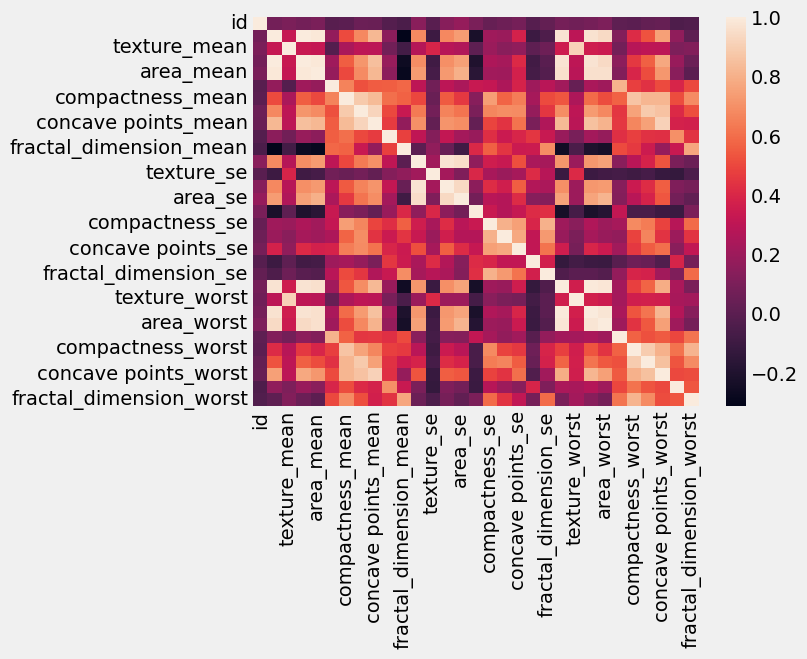

In [18]:
sns.heatmap(train.drop(['diagnosis'], axis = 1).corr())

## Tensor Operations and Custom Datasets
A useful class we can add is the TensorOps class, this one will be used to Tensors and to PyTorch DataLoaders

The other class, CustomDataset, allows us to easily iterate over the Dataset

In [19]:
# Tensor Ops
class TensorOps():
    def __init__(self):
        super(TensorOps, self).__init__()

    def convert_to_tensor(self, X, y=None):
        X_tensor = torch.from_numpy(X).float()
        y_tensor = torch.from_numpy(y).float()
        return X_tensor, y_tensor

    def convert_to_test_tensor(self, X):
        X_tensor = torch.from_numpy(X).float()
        return X_tensor

    def get_dataloaders(self, train_dataset, val_dataset):
        train_loaders = DataLoader(train_dataset, batch_size=2, shuffle=True)
        val_loaders = DataLoader(val_dataset, batch_size=2)
        return train_loaders, val_loaders

    def get_test_dataloaders(self, test_dataset, X_test):
        test_loaders = DataLoader(test_dataset, batch_size=X_test.shape[0])
        return test_loaders
    
tenops = TensorOps()

In [20]:
# custom dataset
class CustomDataset(Dataset):
    def __init__(self, X_data, y_data=None, is_train=True):
        super().__init__()
        if is_train:
            self.X_data = X_data
            self.y_data = y_data
        else:
            self.X_data = X_train

    def __getitem__(self, index):
        return (self.X_data[index], self.y_data[index])

    def __len__(self):
        return len(self.X_data)

With these 2 in place, we can convert our dataset to Tensors -> CustomDataset -> DataLoadersX_tensor_train, y_tensor_train = tenops.convert_to_tensor(X_train.to_numpy(), y_train.values)
X_tensor_val, y_tensor_val = tenops.convert_to_tensor(X_val.to_numpy(), y_val.values)
print(f'Training tensor\n{X_tensor_train}\n\n{y_tensor_train}', X_tensor_train, y_tensor_train)

In [21]:
X_tensor_train, y_tensor_train = tenops.convert_to_tensor(X_train.to_numpy(), y_train.values)
X_tensor_val, y_tensor_val = tenops.convert_to_tensor(X_val.to_numpy(), y_val.values)
print(f'Training tensor\n{X_tensor_train}\n\n{y_tensor_train}', X_tensor_train, y_tensor_train)

Training tensor
tensor([[1.7990e+01, 1.0380e+01, 1.2280e+02,  ..., 2.6540e-01, 4.6010e-01,
         1.1890e-01],
        [2.0570e+01, 1.7770e+01, 1.3290e+02,  ..., 1.8600e-01, 2.7500e-01,
         8.9020e-02],
        [1.9690e+01, 2.1250e+01, 1.3000e+02,  ..., 2.4300e-01, 3.6130e-01,
         8.7580e-02],
        ...,
        [1.3660e+01, 1.9130e+01, 8.9460e+01,  ..., 1.4070e-01, 2.7440e-01,
         8.8390e-02],
        [9.7420e+00, 1.9120e+01, 6.1930e+01,  ..., 4.5890e-02, 3.1960e-01,
         8.0090e-02],
        [1.0030e+01, 2.1280e+01, 6.3190e+01,  ..., 2.5790e-02, 2.3490e-01,
         8.0610e-02]])

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 1.,
        1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0.,
        1., 1., 0., 1., 0., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1.,

In [22]:
train_dataset = CustomDataset(X_tensor_train, y_tensor_train)
val_dataset = CustomDataset(X_tensor_val, y_tensor_val)

train_dataloader = DataLoader(train_dataset, 1, shuffle=False)
val_dataloader = DataLoader(val_dataset, 1)

Our datasets are ready to be fed to a Neural Network, let's prepare that next.

We're creating a Classification class with multiple layers, the output layer is a sigmoid that returns the likelihood of each training example being a Benign or Malignant

In [23]:
class Classification(nn.Module):
    def __init__(self):
        super(Classification, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(30, 54),
            nn.ReLU(),
            nn.Linear(54, 40),
            nn.ReLU(),
            nn.Linear(40, 20),
            nn.ReLU(),
            nn.Linear(20, 10),
            nn.ReLU(),
            nn.Linear(10, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.network(x)

In [24]:
model = Classification()
model

Classification(
  (network): Sequential(
    (0): Linear(in_features=30, out_features=54, bias=True)
    (1): ReLU()
    (2): Linear(in_features=54, out_features=40, bias=True)
    (3): ReLU()
    (4): Linear(in_features=40, out_features=20, bias=True)
    (5): ReLU()
    (6): Linear(in_features=20, out_features=10, bias=True)
    (7): ReLU()
    (8): Linear(in_features=10, out_features=1, bias=True)
    (9): Sigmoid()
  )
)

Next, we create our optimizer, I'm using Adam though other, probably better options exist for this task.

The betas argument to the Adam optimizer controls the exponential decay rates of the first and second moments of the gradients. The first moment is a running average of the gradients, and the second moment is a running average of the squared gradients.

The Adam optimizer uses these moments to compute the adaptive learning rates for each parameter. The first moment is used to estimate the direction of the gradient, and the second moment is used to estimate the magnitude of the gradient.

The amsgrad argument to the Adam optimizer controls whether to use the AMSGrad variant of the Adam optimizer. The AMSGrad optimizer is a modification of the Adam optimizer that uses a more sophisticated method for computing the second moment of the gradients.

The eps argument to the Adam optimizer controls the numerical stability of the optimizer. The eps argument is added to the denominator of the update equations to prevent division by zero.

In [25]:
optimizer = optim.Adam(model.parameters(), betas=[0.9, 0.999], eps=1e-8, amsgrad=True)

Lastly, we create a learning loop (using TQDM for a nice loading bar) as well as collecting the losses

In [26]:
losses = []
for epoch in tqdm(range(50)):
    #print(f"Epoch: {epoch}")
    loss = 0
    for i, (data, target) in enumerate(train_dataloader):
        predictions = model(data)

        loss = F.binary_cross_entropy(predictions, target.unsqueeze(1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    losses.append(loss)
        

  0%|          | 0/50 [00:00<?, ?it/s]

Plotting our loss

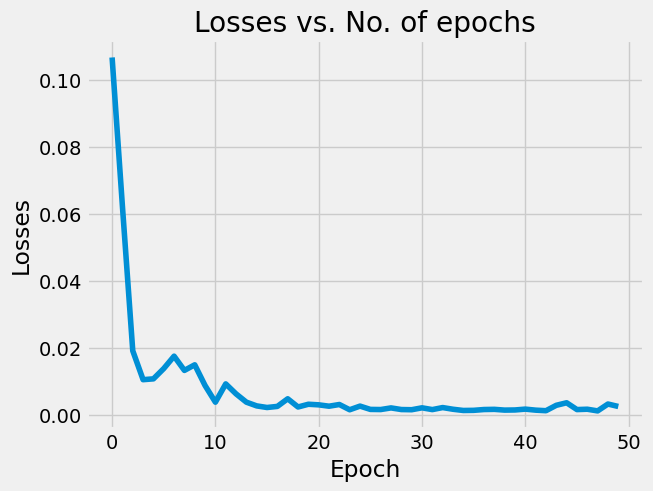

In [27]:
""" Plot the history of loses"""
losses = torch.tensor(losses).numpy()
y = list(range(len(losses)))
plt.plot(y, losses)
plt.xlabel('Epoch')
plt.ylabel('Losses')
plt.title('Losses vs. No. of epochs')
plt.show()

We can use our X_val dataset to see how accurate our model is, not that the output layer returns a float value between 0 and 1, we can apply a threshold at 0.5 that converts these values to either a 0 or 1 

In [29]:
y_pred = model(X_tensor_val).detach().numpy()
y_pred = (y_pred > 0.5).astype(int)

Finally, we use scikit-learn's metrics.accuracy_score to calculate our accuracy percentage, comparing `y_val` and `y_pred`

In [30]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_val, y_pred)
print(f"Accuracy Score: {(100 - acc):.2f}%") 

Accuracy Score: 99.06%
